## Part II: Predicting Hall of Fame Careers

In [259]:
# Import data to dataframes
import pandas as pd

master_df = pd.read_csv('Master.csv', usecols=['playerID','nameFirst','nameLast','bats','throws','debut','finalGame'])
fielding_df = pd.read_csv('Fielding.csv', usecols=['playerID','yearID','stint','teamID','lgID','POS','G','GS','InnOuts','PO','A','E','DP'])
awards_df = pd.read_csv('AwardsPlayers.csv', usecols=['playerID','awardID','yearID'])
allstar_df = pd.read_csv('AllstarFull.csv', usecols=['playerID','yearID'])
hof_df = pd.read_csv('HallOfFame.csv', usecols=['playerID','yearid','votedBy','needed_note','inducted','category'])
batting_df = pd.read_csv('Batting.csv')
appearances_df = pd.read_csv('Appearances.csv')

In [260]:
print(batting_df.head())

    playerID  yearID  stint teamID lgID   G   AB   R   H  2B  ...    RBI   SB  \
0  abercda01    1871      1    TRO  NaN   1    4   0   0   0  ...    0.0  0.0   
1   addybo01    1871      1    RC1  NaN  25  118  30  32   6  ...   13.0  8.0   
2  allisar01    1871      1    CL1  NaN  29  137  28  40   4  ...   19.0  3.0   
3  allisdo01    1871      1    WS3  NaN  27  133  28  44  10  ...   27.0  1.0   
4  ansonca01    1871      1    RC1  NaN  25  120  29  39  11  ...   16.0  6.0   

    CS  BB   SO  IBB  HBP  SH  SF  GIDP  
0  0.0   0  0.0  NaN  NaN NaN NaN   NaN  
1  1.0   4  0.0  NaN  NaN NaN NaN   NaN  
2  1.0   2  5.0  NaN  NaN NaN NaN   NaN  
3  1.0   0  2.0  NaN  NaN NaN NaN   NaN  
4  2.0   2  1.0  NaN  NaN NaN NaN   NaN  

[5 rows x 22 columns]


In [261]:
# Create dictionaries for player stats and years played from the batting_df data frame

player_stats = {}
years_played = {}
for i, row in batting_df.iterrows():
    playerID = row['playerID']
    G = row['G']
    AB = row['AB']
    R = row['R']
    H = row['H']
    twoB = row['2B']
    threeB = row['3B']
    HR = row['HR']
    RBI = row['RBI']
    SB = row['SB']
    CS = row['CS']
    BB = row['BB']
    SO = row['SO']
    IBB = row['IBB']
    HBP = row['HBP']
    SH = row['SH']
    SF = row['SF']
    GIDP = row['GIDP']
    yearID = row['yearID']
    if playerID in player_stats:
        player_stats[playerID]['G'] = player_stats[playerID]['G'] + G
        player_stats[playerID]['AB'] = player_stats[playerID]['AB'] + AB
        player_stats[playerID]['R'] = player_stats[playerID]['R'] + R
        player_stats[playerID]['H'] = player_stats[playerID]['H'] + H
        player_stats[playerID]['2B'] = player_stats[playerID]['2B'] + twoB
        player_stats[playerID]['3B'] = player_stats[playerID]['3B'] + threeB
        player_stats[playerID]['HR'] = player_stats[playerID]['HR'] + HR
        player_stats[playerID]['RBI'] = player_stats[playerID]['RBI'] + RBI
        player_stats[playerID]['SB'] = player_stats[playerID]['SB'] + SB
        player_stats[playerID]['CS'] = player_stats[playerID]['CS'] + CS
        player_stats[playerID]['BB'] = player_stats[playerID]['BB'] + BB
        player_stats[playerID]['SO'] = player_stats[playerID]['SO'] + SO
        player_stats[playerID]['IBB'] = player_stats[playerID]['IBB'] + IBB
        player_stats[playerID]['HBP'] = player_stats[playerID]['HBP'] + HBP
        player_stats[playerID]['SH'] = player_stats[playerID]['SH'] + SH
        player_stats[playerID]['SF'] = player_stats[playerID]['SF'] + SF
        player_stats[playerID]['GIDP'] = player_stats[playerID]['GIDP'] + GIDP
        years_played[playerID].append(yearID)        
    else:
        player_stats[playerID] = {}
        player_stats[playerID]['G'] = G
        player_stats[playerID]['AB'] = AB
        player_stats[playerID]['R'] = R
        player_stats[playerID]['H'] = H
        player_stats[playerID]['2B'] = twoB
        player_stats[playerID]['3B'] = threeB
        player_stats[playerID]['HR'] = HR
        player_stats[playerID]['RBI'] = RBI
        player_stats[playerID]['SB'] = SB
        player_stats[playerID]['CS'] = CS
        player_stats[playerID]['BB'] = BB
        player_stats[playerID]['SO'] = SO
        player_stats[playerID]['IBB'] = IBB
        player_stats[playerID]['HBP'] = HBP
        player_stats[playerID]['SH'] = SH
        player_stats[playerID]['SF'] = SF
        player_stats[playerID]['GIDP'] = GIDP
        years_played[playerID] = []
        years_played[playerID].append(yearID)

In [262]:
# Iterate through the years played list and add the number of years played to the player_stats dictionary

for k, v in years_played.items():
    player_stats[k]['Years_Played'] = len(list(set(v)))

In [263]:
# Add fielding stats to player_stats dictionary from the fielding_df dataframe
fielder_list = []
for i, row in fielding_df.iterrows():
    playerID = row['playerID']
    Gf = row['G']
    GSf = row['GS']
    InnOutsf = row['InnOuts']
    POf = row['PO']
    Af = row['A']
    Ef = row['E']
    DPf = row['DP']
    if playerID in player_stats and playerID in fielder_list:
        player_stats[playerID]['Gf'] = player_stats[playerID]['Gf'] + Gf
        player_stats[playerID]['GSf'] = player_stats[playerID]['GSf'] + GSf
        player_stats[playerID]['InnOutsf'] = player_stats[playerID]['InnOutsf'] + InnOutsf
        player_stats[playerID]['POf'] = player_stats[playerID]['POf'] + POf
        player_stats[playerID]['Af'] = player_stats[playerID]['Af'] + Af
        player_stats[playerID]['Ef'] = player_stats[playerID]['Ef'] + Ef
        player_stats[playerID]['DPf'] = player_stats[playerID]['DPf'] + DPf
    else:
        fielder_list.append(playerID)
        player_stats[playerID]['Gf'] = Gf
        player_stats[playerID]['GSf'] = GSf
        player_stats[playerID]['InnOutsf'] = InnOutsf
        player_stats[playerID]['POf'] = POf
        player_stats[playerID]['Af'] = Af
        player_stats[playerID]['Ef'] = Ef
        player_stats[playerID]['DPf'] = DPf


In [264]:
# Print out unique awards from the awards_df dataframe
print(awards_df['awardID'].unique())

['Pitching Triple Crown' 'Triple Crown' 'Baseball Magazine All-Star'
 'Most Valuable Player' 'TSN All-Star' 'TSN Guide MVP'
 'TSN Major League Player of the Year' 'TSN Pitcher of the Year'
 'TSN Player of the Year' 'Rookie of the Year' 'Babe Ruth Award'
 'Lou Gehrig Memorial Award' 'World Series MVP' 'Cy Young Award'
 'Gold Glove' 'TSN Fireman of the Year' 'All-Star Game MVP' 'Hutch Award'
 'Roberto Clemente Award' 'Rolaids Relief Man Award' 'NLCS MVP' 'ALCS MVP'
 'Silver Slugger' 'Branch Rickey Award' 'Hank Aaron Award'
 'TSN Reliever of the Year' 'Comeback Player of the Year'
 'Outstanding DH Award' 'Reliever of the Year Award']


In [265]:
# Create dataframes for each award by filtering awards_df and include each dataframe in a list called awards_list
mvp_df = awards_df[awards_df['awardID'] == 'Most Valuable Player']
roy_df = awards_df[awards_df['awardID'] == 'Rookie of the Year']
gg_df = awards_df[awards_df['awardID'] == 'Gold Glove']
ss_df = awards_df[awards_df['awardID'] == 'Silver Slugger']
ws_mvp_df = awards_df[awards_df['awardID'] == 'World Series MVP']
awards_list = [mvp_df,roy_df,gg_df,ss_df,ws_mvp_df]

# lists for each of the above dataframes, and include each list in another list
mvp_list = []
roy_list = []
gg_list = []
ss_list = []
ws_mvp_list = []
lists = [mvp_list,roy_list,gg_list,ss_list,ws_mvp_list]

# Add a count for each award for each player in the player_stats dictionary
for index, v in enumerate(awards_list):
    for i, row in v.iterrows():
        playerID = row['playerID']
        award = row['awardID']
        if playerID in player_stats and playerID in lists[index]:
            player_stats[playerID][award] += 1
        else:
            lists[index].append(playerID)
            player_stats[playerID][award] = 1

In [266]:
# Add a count for each Allstar game appearance for each player in the player_stats dictionary
allstar_list = []
for i, row in allstar_df.iterrows():
    playerID = row['playerID']
    if playerID in player_stats and playerID in allstar_list:
        player_stats[playerID]['AS_games'] += 1
    else:
        allstar_list.append(playerID)
        player_stats[playerID]['AS_games'] = 1

In [267]:
# filter the hof_df to include only instances where a player was inducted into the Hall of Fame
hof_df = hof_df[(hof_df['inducted'] == 'Y') & (hof_df['category'] == 'Player')]

# Indicate which players in the player_stats dictionary were inducted into the Hall of Fame
for i, row in hof_df.iterrows():
    playerID = row['playerID']
    if playerID in player_stats:
        player_stats[playerID]['HoF'] = 1
        player_stats[playerID]['votedBy'] = row['votedBy']

In [268]:
print(len(hof_df))
print(len(master_df))

250
19105


In [269]:
# Convert the player_stats dictionary into a dataframe
stats_df = pd.DataFrame.from_dict(player_stats, orient='index')
# Add a column for playerID from the stats_df index
stats_df['playerID'] = stats_df.index
# Join the stats_df and master_df dataframes
master_df = master_df.join(stats_df,on='playerID',how='inner', rsuffix='mstr')


In [270]:
# Create a function to convert the bats and throws colums to numeric
def bats_throws(col):
    if col == "R":
        return 1
    else:
        return 0

# Use the apply method to create numeric columns from the bats and throws columns
master_df['bats_R'] = master_df['bats'].apply(bats_throws)
master_df['throws_R'] = master_df['throws'].apply(bats_throws)

In [271]:
print(appearances_df.head())

   yearID teamID lgID   playerID  G_all  GS  G_batting  G_defense  G_p  G_c  \
0    1871    TRO  NaN  abercda01      1 NaN          1          1    0    0   
1    1871    RC1  NaN   addybo01     25 NaN         25         25    0    0   
2    1871    CL1  NaN  allisar01     29 NaN         29         29    0    0   
3    1871    WS3  NaN  allisdo01     27 NaN         27         27    0   27   
4    1871    RC1  NaN  ansonca01     25 NaN         25         25    0    5   

   ...   G_2b  G_3b  G_ss  G_lf  G_cf  G_rf  G_of  G_dh  G_ph  G_pr  
0  ...      0     0     1     0     0     0     0   NaN   NaN   NaN  
1  ...     22     0     3     0     0     0     0   NaN   NaN   NaN  
2  ...      2     0     0     0    29     0    29   NaN   NaN   NaN  
3  ...      0     0     0     0     0     0     0   NaN   NaN   NaN  
4  ...      2    20     0     1     0     0     1   NaN   NaN   NaN  

[5 rows x 21 columns]


In [272]:
# Iterate through the appearances_df dataframe and add a count for the number of appearances for each player at each position  
# Also, add a count for the number of games played for each player in each era. 
pos_dict = {}
pos_list = []
for i, row in appearances_df.iterrows():
    ID = row['playerID']
    year = row['yearID']
    if ID in pos_dict:
        pos_dict[ID]['G_all'] = pos_dict[ID]['G_all'] + row['G_all']
        pos_dict[ID]['G_p'] = pos_dict[ID]['G_p'] + row['G_p'] 
        pos_dict[ID]['G_c'] = pos_dict[ID]['G_c'] + row['G_c'] 
        pos_dict[ID]['G_1b'] = pos_dict[ID]['G_1b'] + row['G_1b'] 
        pos_dict[ID]['G_2b'] = pos_dict[ID]['G_2b'] + row['G_2b'] 
        pos_dict[ID]['G_3b'] = pos_dict[ID]['G_3b'] + row['G_3b'] 
        pos_dict[ID]['G_ss'] = pos_dict[ID]['G_ss'] + row['G_ss'] 
        pos_dict[ID]['G_lf'] = pos_dict[ID]['G_lf'] + row['G_lf'] 
        pos_dict[ID]['G_cf'] = pos_dict[ID]['G_cf'] + row['G_cf'] 
        pos_dict[ID]['G_rf'] = pos_dict[ID]['G_rf'] + row['G_rf'] 
        pos_dict[ID]['G_of'] = pos_dict[ID]['G_of'] + row['G_of'] 
        pos_dict[ID]['G_dh'] = pos_dict[ID]['G_dh'] + row['G_dh']
        if year < 1920:
            pos_dict[ID]['pre1920'] = pos_dict[ID]['pre1920'] + row['G_all']
        elif year >= 1920 and year <= 1941:
            pos_dict[ID]['1920-41'] = pos_dict[ID]['1920-41'] + row['G_all']
        elif year >= 1942 and year <= 1945:
            pos_dict[ID]['1942-45'] = pos_dict[ID]['1942-45'] + row['G_all']
        elif year >= 1946 and year <= 1962:
            pos_dict[ID]['1946-62'] = pos_dict[ID]['1946-62'] + row['G_all']
        elif year >= 1963 and year <= 1976:
            pos_dict[ID]['1963-76'] = pos_dict[ID]['1963-76'] + row['G_all']
        elif year >= 1977 and year <= 1992:
            pos_dict[ID]['1977-92'] = pos_dict[ID]['1977-92'] + row['G_all']
        elif year >= 1993 and year <= 2009:
            pos_dict[ID]['1993-2009'] = pos_dict[ID]['1993-2009'] + row['G_all']     
        elif year > 2009:
            pos_dict[ID]['post2009'] = pos_dict[ID]['post2009'] + row['G_all']  
    else:
        pos_dict[ID] = {}
        pos_dict[ID]['G_all'] = row['G_all']
        pos_dict[ID]['G_p'] = row['G_p'] 
        pos_dict[ID]['G_c'] = row['G_c'] 
        pos_dict[ID]['G_1b'] = row['G_1b'] 
        pos_dict[ID]['G_2b'] = row['G_2b'] 
        pos_dict[ID]['G_3b'] = row['G_3b'] 
        pos_dict[ID]['G_ss'] = row['G_ss'] 
        pos_dict[ID]['G_lf'] = row['G_lf'] 
        pos_dict[ID]['G_cf'] = row['G_cf'] 
        pos_dict[ID]['G_rf'] = row['G_rf'] 
        pos_dict[ID]['G_of'] = row['G_of'] 
        pos_dict[ID]['G_dh'] = row['G_dh']
        pos_dict[ID]['pre1920'] = 0
        pos_dict[ID]['1920-41'] = 0
        pos_dict[ID]['1942-45'] = 0
        pos_dict[ID]['1946-62'] = 0
        pos_dict[ID]['1963-76'] = 0
        pos_dict[ID]['1977-92'] = 0
        pos_dict[ID]['1993-2009'] = 0
        pos_dict[ID]['post2009'] = 0
        if year < 1920:
            pos_dict[ID]['pre1920'] = row['G_all']
        elif year >= 1920 and year <= 1941:
            pos_dict[ID]['1920-41'] = row['G_all']
        elif year >= 1942 and year <= 1945:
            pos_dict[ID]['1942-45'] = row['G_all']
        elif year >= 1946 and year <= 1962:
            pos_dict[ID]['1946-62'] = row['G_all']
        elif year >= 1963 and year <= 1976:
            pos_dict[ID]['1963-76'] = row['G_all']
        elif year >= 1977 and year <= 1992:
            pos_dict[ID]['1977-92'] = row['G_all']
        elif year >= 1993 and year <= 2009:
            pos_dict[ID]['1993-2009'] = row['G_all']     
        elif year > 2009:
            pos_dict[ID]['post2009'] = row['G_all']

In [273]:
# Convert the pos_dict dictionary to a dataframe and then print the columns
pos_df = pd.DataFrame.from_dict(pos_dict, orient='index')
print(pos_df.columns)

Index(['pre1920', '1977-92', 'G_2b', 'G_c', '1946-62', 'G_lf', '1993-2009',
       'G_cf', 'G_all', 'G_p', '1920-41', 'G_3b', 'G_rf', 'post2009',
       '1942-45', 'G_1b', 'G_dh', 'G_of', 'G_ss', '1963-76'],
      dtype='object')


In [274]:
# Create a list that contains columns for each era and position
pos_col_list = ['pre1920', '1920-41', '1942-45', '1946-62', '1963-76', '1977-92', '1993-2009', 'post2009',
'G_p', 'G_c', 'G_1b', 'G_dh', 'G_cf',  'G_ss', 'G_2b', 'G_3b', 'G_rf', 'G_lf', 'G_of']

# Loop through the list and divide each column by the players total games played
for col in pos_col_list:
    column = col + '_percent'
    pos_df[column] = pos_df[col] / pos_df['G_all']

In [275]:
print(pos_df.head())

           pre1920  1977-92  G_2b  G_c  1946-62  G_lf  1993-2009  G_cf  G_all  \
aardsda01        0        0     0    0        0     0        201     0    331   
aaronha01        0        0    43    0     1350   315          0   308   3298   
aaronto01        0        0     7    0      141   135          0     1    437   
aasedo01         0      448     0    0        0     0          0     0    448   
abadan01         0        0     0    0        0     0         15     0     15   

           G_p      ...       G_c_percent  G_1b_percent  G_dh_percent  \
aardsda01  331      ...               0.0      0.000000      0.000000   
aaronha01    0      ...               0.0      0.063675      0.060946   
aaronto01    0      ...               0.0      0.530892      0.000000   
aasedo01   448      ...               0.0      0.000000      0.000000   
abadan01     0      ...               0.0      0.533333      0.000000   

           G_cf_percent  G_ss_percent  G_2b_percent  G_3b_percent  \
aards

In [276]:
# Filter the pos_df dataframe to eliminate players who played 10% or more of their games as Pitchers or Catchers
pos_df = pos_df[(pos_df['G_p_percent'] < 0.1) & (pos_df['G_c_percent'] < 0.1)]
print(len(pos_df))

8175


In [277]:
# Join the pos_df and master_df dataframes
master_df = master_df.join(pos_df,on='playerID',how='right')

In [278]:
# Filter the master_df dataframe to include only players who were voted into the Hall of Fame or Players who did not make it at all
master_df['votedBy'] = master_df['votedBy'].fillna('None')
master_df = master_df[(master_df['votedBy'] == 'None') | (master_df['votedBy'] == 'BBWAA') | (master_df['votedBy'] == 'Run Off')]

In [279]:
# Convert the debut and finalGame columns to datetimes and create new columns for debutYear and finalYear
from datetime import datetime
master_df['debut'] =  pd.to_datetime(master_df['debut'])
master_df['finalGame'] = pd.to_datetime(master_df['finalGame'])
master_df['debutYear'] = pd.to_numeric(master_df['debut'].dt.strftime('%Y'), errors='coerce')
master_df['finalYear'] = pd.to_numeric(master_df['finalGame'].dt.strftime('%Y'), errors='coerce')

In [280]:
# Eliminating unnecessary columns
df = master_df.drop(['votedBy', 'CS', 'IBB', 'bats', 'throws','GIDP','GSf', 'POf','Gf', 'InnOutsf', 'SH', 'playerIDmstr'], axis=1)

In [281]:
# Print df columns and a list of null values
print(df.columns)
print(df.isnull().sum(axis=0).tolist())

Index(['playerID', 'nameFirst', 'nameLast', 'debut', 'finalGame', 'G', 'DPf',
       'AB', 'SB', 'HBP', 'Af', '2B', 'Ef', 'RBI', 'SO', 'H', '3B', 'HR',
       'Years_Played', 'R', 'SF', 'BB', 'AS_games', 'Most Valuable Player',
       'Gold Glove', 'Silver Slugger', 'Rookie of the Year', 'HoF',
       'World Series MVP', 'bats_R', 'throws_R', 'pre1920', '1977-92', 'G_2b',
       'G_c', '1946-62', 'G_lf', '1993-2009', 'G_cf', 'G_all', 'G_p',
       '1920-41', 'G_3b', 'G_rf', 'post2009', '1942-45', 'G_1b', 'G_dh',
       'G_of', 'G_ss', '1963-76', 'pre1920_percent', '1920-41_percent',
       '1942-45_percent', '1946-62_percent', '1963-76_percent',
       '1977-92_percent', '1993-2009_percent', 'post2009_percent',
       'G_p_percent', 'G_c_percent', 'G_1b_percent', 'G_dh_percent',
       'G_cf_percent', 'G_ss_percent', 'G_2b_percent', 'G_3b_percent',
       'G_rf_percent', 'G_lf_percent', 'G_of_percent', 'debutYear',
       'finalYear'],
      dtype='object')
[0, 28, 0, 0, 0, 0, 202, 0, 

In [282]:
# Fill null values in numeric columns with 0
fill_cols = ['AS_games', 'Silver Slugger', 'Rookie of the Year', 'Gold Glove', 'Most Valuable Player', 'HoF',
'1977-92', 'pre1920', '1942-45', '1946-62', '1963-76', '1920-41', '1993-2009', 'HBP', 'SB', 'SF', 'RBI', 'SO', 'World Series MVP', 'G_dh_percent', 'G_dh', 'Af', 'DPf', 'Ef']

for col in fill_cols:
    df[col] = df[col].fillna(0)

# Drop any additional rows with null values
df = df.dropna()

print(df.isnull().sum(axis=0).tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [283]:
# Create Batting Average column
df['AVE'] = df['H'] / df['AB']

# Create On Base Percent column
df['OBP'] = (df['H'] + df['BB']) / (df['AB'] + df['BB'])

# Create Slugging Percent column
df['Slug_Percent'] = ((df['HR'] * 4) + (df['3B'] * 3) + (df['2B'] * 2) + (df['H'] - df['2B'] - df['3B'] - df['HR'])) / df['AB']

# Create On Base plus Slugging Percent column
hr = df['HR'] * 4
triple = df['3B'] * 3
double = df['2B'] * 2
single = ((df['H'] - df['2B']) - df['3B']) - df['HR']
df['OPS'] = ((df['H'] + df['BB'] + df['HBP']) / (df['AB'] + df['BB'] + df['SF'] + df['HBP'])) + ((single + double + triple + hr)/ df['AB'])

In [284]:
# Find rows for Shoeless Joe Jackson and Pete Rose 
rose = df[df['H'] > 4000]
print(rose)

jackson = df[(df['AVE'] > .35) & (df['G'] > 1000)]
print(jackson)

       playerID nameFirst nameLast      debut  finalGame     G     DPf     AB  \
3182   cobbty01        Ty     Cobb 1905-08-30 1928-09-11  3035   113.0  11434   
14860  rosepe01      Pete     Rose 1963-04-08 1986-08-17  3562  1083.0  14053   

          SB    HBP    ...     G_3b_percent  G_rf_percent  G_lf_percent  \
3182   892.0   94.0    ...          0.00033      0.235003      0.012195   
14860  198.0  107.0    ...          0.17799      0.165357      0.188939   

       G_of_percent  debutYear  finalYear       AVE       OBP  Slug_Percent  \
3182       0.967040       1905       1928  0.366363  0.428763      0.511982   
14860      0.372544       1963       1986  0.302853  0.372751      0.409308   

            OPS  
3182   0.944947  
14860  0.784442  

[2 rows x 76 columns]
       playerID     nameFirst nameLast      debut  finalGame     G     DPf  \
3182   cobbty01            Ty     Cobb 1905-08-30 1928-09-11  3035   113.0   
7967  hornsro01        Rogers  Hornsby 1915-09-10 1937-07-2

In [285]:
# Eliminate Jackson and Rose from the dataframe 
df = df[(df['playerID'] != 'rosepe01') & (df['playerID'] != 'jacksjo01')]

In [286]:
# Make a function that will create a new column to honor Jackie Robinson, the first African American Major league Baseball Player
def first_aap(col):
    if col == 'robinja02':
        return 1
    else:
        return 0
    
df['first_aap'] = df['playerID'].apply(first_aap)

In [287]:
# Filter the df dataframe for the remaining Hall of Fame members in the data and print the length of the new dataframe
df_hof = df[df['HoF'] == 1]
print(len(df_hof))

70


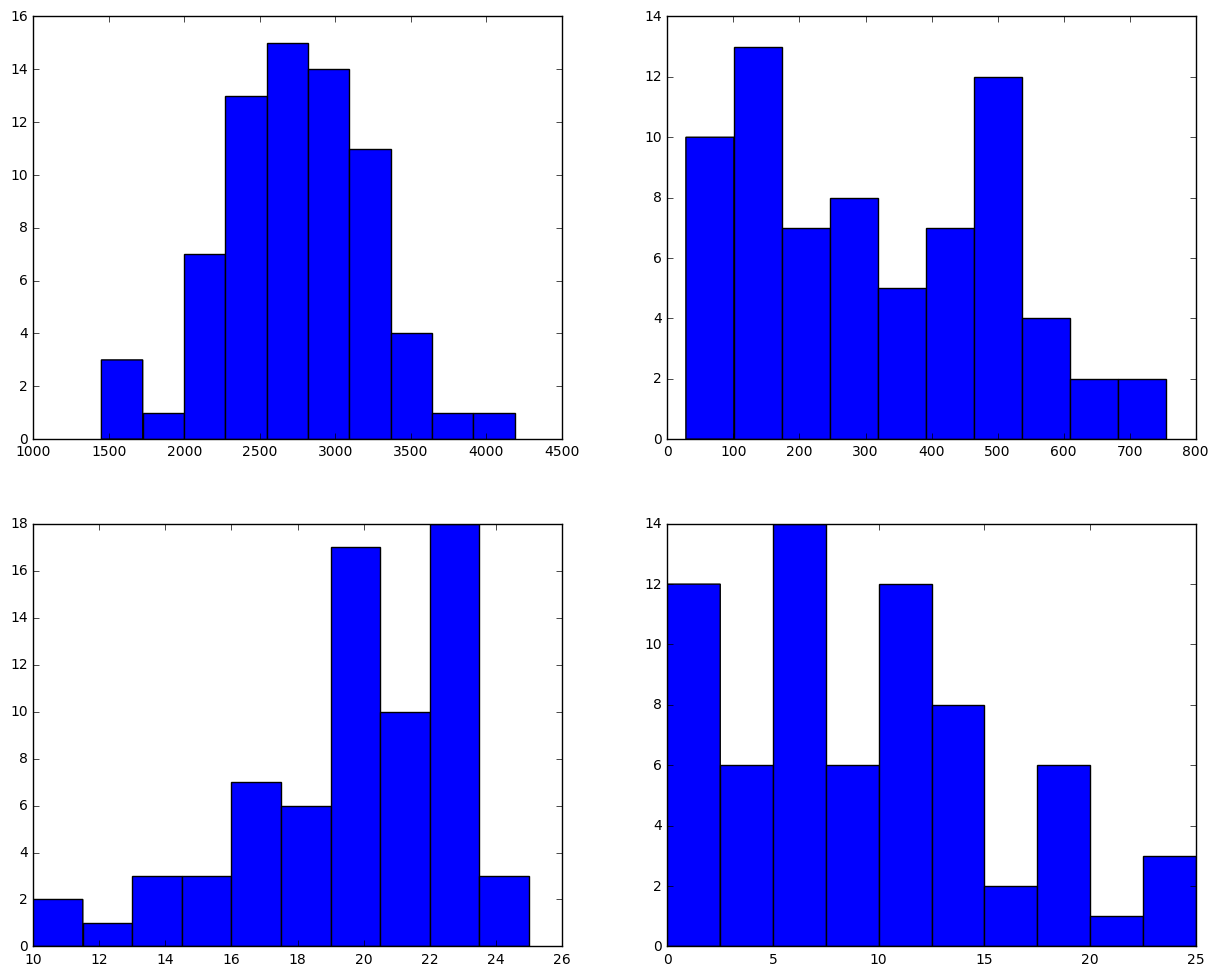

In [288]:
import matplotlib.pyplot as plt
%matplotlib inline

# Create distribution plots for Hits, Home Runs, Years Played and All Star Games
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
ax1.hist(df_hof['H'])
ax2.hist(df_hof['HR'])
ax3.hist(df_hof['Years_Played'])
ax4.hist(df_hof['AS_games'])
plt.show()

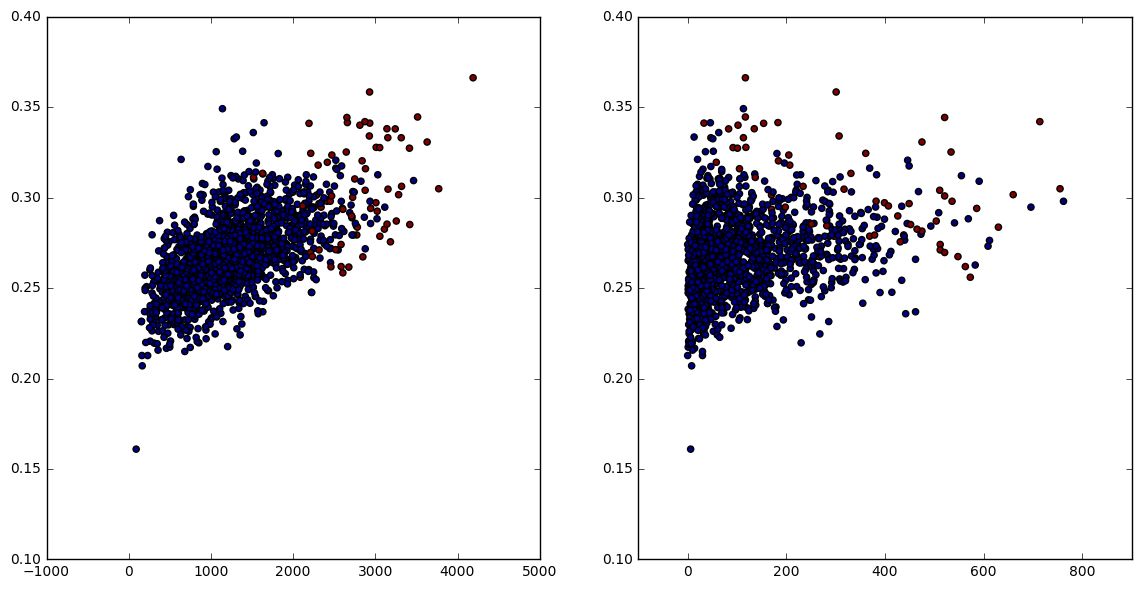

In [289]:
# Filter df dataframe for players with 10 or more years of experience
df_10 = df[df['Years_Played'] >= 10]

# Create Scatter plots for Hits vs. Average and Home Runs vs. Average
fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.scatter(df_10['H'], df_10['AVE'], c=df_10['HoF'])
ax2.scatter(df_10['HR'], df_10['AVE'], c=df_10['HoF'])
plt.show()

In [290]:
# Create column for years since retirement
df['YSR'] = 2016 - df['finalYear']

# Filter df dataframe for players who retired more than 15 years ago
df_hitters = df[df['YSR'] > 15]

# Filter df dataframe for players who retired less than 15 years ago and for currently active players
df_eligable = df[df['YSR']<= 15]

In [291]:
print(df.columns)

Index(['playerID', 'nameFirst', 'nameLast', 'debut', 'finalGame', 'G', 'DPf',
       'AB', 'SB', 'HBP', 'Af', '2B', 'Ef', 'RBI', 'SO', 'H', '3B', 'HR',
       'Years_Played', 'R', 'SF', 'BB', 'AS_games', 'Most Valuable Player',
       'Gold Glove', 'Silver Slugger', 'Rookie of the Year', 'HoF',
       'World Series MVP', 'bats_R', 'throws_R', 'pre1920', '1977-92', 'G_2b',
       'G_c', '1946-62', 'G_lf', '1993-2009', 'G_cf', 'G_all', 'G_p',
       '1920-41', 'G_3b', 'G_rf', 'post2009', '1942-45', 'G_1b', 'G_dh',
       'G_of', 'G_ss', '1963-76', 'pre1920_percent', '1920-41_percent',
       '1942-45_percent', '1946-62_percent', '1963-76_percent',
       '1977-92_percent', '1993-2009_percent', 'post2009_percent',
       'G_p_percent', 'G_c_percent', 'G_1b_percent', 'G_dh_percent',
       'G_cf_percent', 'G_ss_percent', 'G_2b_percent', 'G_3b_percent',
       'G_rf_percent', 'G_lf_percent', 'G_of_percent', 'debutYear',
       'finalYear', 'AVE', 'OBP', 'Slug_Percent', 'OPS', 'first_aap', '

In [292]:
# Select columns to use for models, and identification columns
num_cols_hitters = ['playerID', 'nameFirst', 'nameLast', 'HoF', 'Years_Played', 'H', 'BB', 'HR', 'AVE', 'OBP', 'Slug_Percent', 'OPS',  'RBI',
       'R', 'SB',  '2B', '3B', 'AB', 'SO', 'Most Valuable Player', 'World Series MVP', 'AS_games','Gold Glove', 'Rookie of the Year', 
       'Silver Slugger', 'bats_R', 'throws_R', 'DPf', 'Af', 'Ef', 'YSR', 'G_all', 
       '1963-76_percent', '1993-2009_percent', '1946-62_percent', 'G_1b_percent', '1942-45_percent',
       'G_dh_percent', '1920-41_percent', 'G_ss_percent',
       'post2009_percent', '1977-92_percent', 'G_2b_percent', 'G_3b_percent',
       'G_of_percent', 'pre1920_percent', 'first_aap']

# Create a new dataframe (data) from the df_hitters dataframe using the columns above
data = df_hitters[num_cols_hitters]

In [293]:
# Check for null values
print(data.isnull().sum(axis=0).tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 76, 69, 76, 76, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [294]:
# Eliminate rows with null values
data = data.dropna()

In [295]:
# Print length of data and how many Hall of Fame members are in data
print(len(data))
print(len(data[data['HoF'] == 1]))

6239
61


In [296]:
# Create the target series
target = data['HoF']

# Create the features dataframe
features = data.drop(['playerID', 'nameFirst', 'nameLast', 'HoF'], axis=1)

In [297]:
# Import cross_val_predict, KFold and LogisticRegression from 'sklearn'
from sklearn.cross_validation import cross_val_predict, KFold
from sklearn.linear_model import LogisticRegression

# Create Logistic Regression model
lr = LogisticRegression(class_weight='balanced')

# Create an instance of the KFold class
kf = KFold(features.shape[0], random_state=1)

# Create predictions using cross validation
predictions_lr = cross_val_predict(lr, features, target, cv=kf)

In [317]:
# Import NumPy
import numpy as np

# Convert predictions and target to NumPy arrays
np_predictions_lr = np.asarray(predictions_lr)
np_target = target.as_matrix()

In [335]:
# Determine True Positive count
tp_filter_lr = (np_predictions_lr == 1) & (np_target == 1)
tp_lr = len(np_predictions_lr[tp_filter_lr])

# Determine False Negative count
fn_filter_lr = (np_predictions_lr == 0) & (np_target == 1)
fn_lr = len(np_predictions_lr[fn_filter_lr])

# Determine False Positive count
fp_filter_lr = (np_predictions_lr == 1) & (np_target == 0)
fp_lr = len(np_predictions_lr[fp_filter_lr])

# Print each count
print(tp_lr)
print(fn_lr)
print(fp_lr)

54
7
35


In [336]:
# Determine True Positive rate
tpr_lr = tp_lr / (tp_lr + fn_lr)

# Determine False Negative rate
fnr_lr = fn_lr / (fn_lr + tp_lr)

# Determine False Positive rate
fpr_lr = fp_lr / (fp_lr + tn_lr)

# Print each rate
print(tpr_lr)
print(fnr_lr)
print(fpr_lr)

0.8852459016393442
0.11475409836065574
0.0056652638394302365


In [337]:
# Import RandomForestClassifier from sklearn
from sklearn.ensemble import RandomForestClassifier

# Create penalty dictionary
penalty = {
    0: 100,
    1: 1
}

# Create Random Forest model
rf = RandomForestClassifier(random_state=1,n_estimators=12, max_depth=11, min_samples_leaf=1, class_weight=penalty)

# Create predictions using cross validation
predictions_rf = cross_val_predict(rf, features, target, cv=kf)

In [339]:
# Convert predictions to NumPy array
np_predictions_rf = np.asarray(predictions_rf)

In [340]:
# Determine True Positive count
tp_filter_rf = (np_predictions_rf == 1) & (np_target == 1)
tp_rf = len(np_predictions_rf[tp_filter_rf])

# Determine False Negative count
fn_filter_rf = (np_predictions_rf == 0) & (np_target == 1)
fn_rf = len(np_predictions_rf[fn_filter_rf])

# Determine False Positive count
fp_filter_rf = (np_predictions_rf == 1) & (np_target == 0)
fp_rf = len(np_predictions_rf[fp_filter_rf])

# Print each count
print(tp_rf)
print(fn_rf)
print(fp_rf)

In [342]:
# Determine True Positive rate
tpr_rf = tp_rf / (tp_rf + fn_rf)

# Determine False Negative rate
fnr_rf = fn_rf / (fn_rf + tp_rf)

# Determine False Positive rate
fpr_rf = fp_rf / (fp_rf + tn_rf)

# Print each rate
print(tpr_rf)
print(fnr_rf)
print(fpr_rf)

In [344]:
# Create a new dataframe from the df_eligable dataframe using the num_col_hitters list of columns
new_data = df_eligable[num_cols_hitters]

# Print null values list
print(new_data.isnull().sum(axis=0).tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [346]:
# Drop rows with null values
new_data = new_data.dropna()

# Create a new features dataframe
new_features = new_data.drop(['playerID', 'nameFirst', 'nameLast', 'HoF'], axis=1)

In [361]:
# Fit the Random Forest model
rf.fit(features, target)

# Estimate probabilities of Hall of Fame induction
probabilities = rf.predict_proba(new_features)

In [367]:
# Convert predictions to a pandas dataframe and sort descending
hof_predictions = pd.DataFrame(probabilities[:,1])
hof_predictions = hof_predictions.sort_values(0,ascending=False)
hof_predictions['Probability'] = hof_predictions[0]

In [371]:
for i, row in hof_predictions.head(50).iterrows():
    print(row['Probability'])
    print(new_data.iloc[i,1:28])

1.0
nameFirst                Roberto
nameLast                  Alomar
HoF                            1
Years_Played                  17
H                           2724
BB                          1032
HR                           210
AVE                     0.300231
OBP                     0.371697
Slug_Percent            0.442852
OPS                     0.814097
RBI                         1134
R                           1508
SB                           474
2B                           504
3B                            80
AB                          9073
SO                          1140
Most Valuable Player           0
World Series MVP               0
AS_games                      12
Gold Glove                    10
Rookie of the Year             0
Silver Slugger                 4
bats_R                         0
throws_R                       1
DPf                         1411
Name: 245, dtype: object
1.0
nameFirst                 Harold
nameLast                  Baines
HoF       